In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.__version__ #tf version project ran on

'2.13.1'

In [2]:
!nvcc -V && nvidia-smi #gpu info

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Thu Dec 28 16:47:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P5               8W / 111

In [3]:
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.") #useful script

[INFO] 'helper_functions.py' already exists, skipping download.


In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import tensorflow_datasets as tfds

# getting dataset
tf.random.set_seed(58)
(train_data ,test_data), ds_info = tfds.load(name='food101',
                                               split=['train', 'validation'],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)   

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /home/nexus/tensorflow_datasets/food101/2.0.0.incomplete6RZY1T/food101-train.tfrecord*...:   0%|    …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /home/nexus/tensorflow_datasets/food101/2.0.0.incomplete6RZY1T/food101-validation.tfrecord*...:   0%…

Dataset food101 downloaded and prepared to /home/nexus/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
# dataset info
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [7]:
sample = train_data.take(1)
sample
# image info
for image, label in sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 19
  Class name (str form): chicken_quesadilla
        


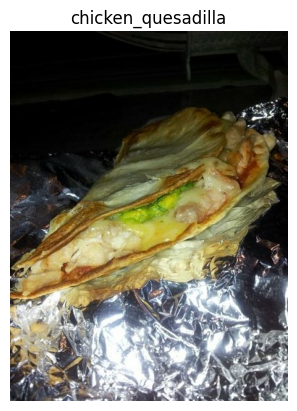

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

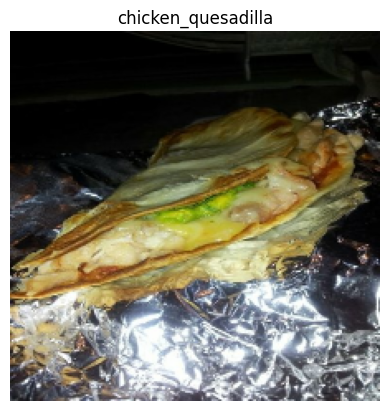

In [9]:
# preprocessing

def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image,[img_shape,img_shape])
    return tf.cast(image,tf.float32),label

# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [10]:

# Map preprocessing function to training data (and paralellize)
tf.random.set_seed(58)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [12]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      )

In [13]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


<Policy "mixed_float16">

In [14]:
from tensorflow.keras import layers

INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pool_layer')(x)
x = layers.Dense(len(class_names),name='output_layer')(x)
outputs = layers.Activation('softmax', dtype= tf.float32, name='activation_layer')(x)

model = tf.keras.Model(inputs,outputs)

# compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pool_layer (GlobalAverageP  (None, 1280)              0         
 ooling2D)                                                       
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_layer (Activati  (None, 101)               0         
 on)                                                             
                                                             

In [16]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
pool_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


In [17]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy

In [18]:
tf.get_logger().setLevel('ERROR')


history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[create_tensorboard_callback('training_logs','Deep_Food_Model'), 
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/Deep_Food_Model/20231228-165447
Epoch 1/3
2368/2368 [==============================] - 81s 31ms/step - loss: 1.7460 - accuracy: 0.5771 - val_loss: 1.1532 - val_accuracy: 0.6939
Epoch 2/3
2368/2368 [==============================] - 72s 30ms/step - loss: 1.2131 - accuracy: 0.6877 - val_loss: 1.0288 - val_accuracy: 0.7238
Epoch 3/3
2368/2368 [==============================] - 73s 30ms/step - loss: 1.0654 - accuracy: 0.7221 - val_loss: 0.9916 - val_accuracy: 0.7365


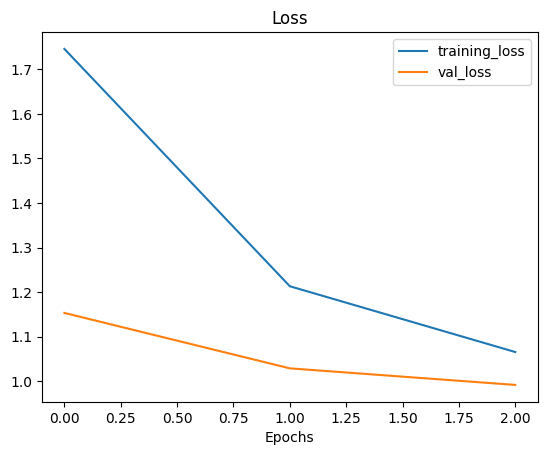

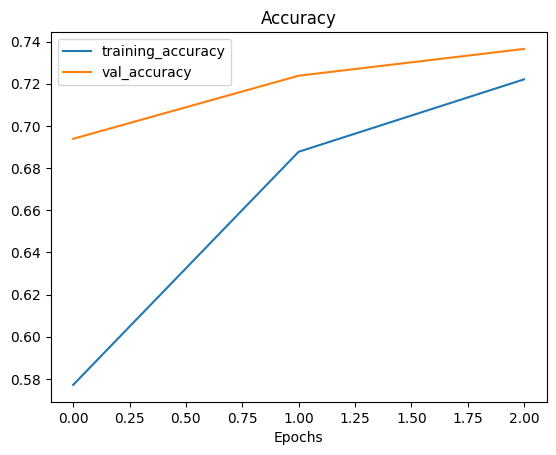

In [19]:
plot_loss_curves(history)

In [20]:
base_evaluation = model.evaluate(test_data)

790/790 [==============================] - 22s 28ms/step - loss: 0.9960 - accuracy: 0.7299


In [24]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  # input_shape = (224, 224, 3)
  # base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  # base_model.trainable = False # freeze base model layers

  # # Create Functional model 
  # inputs = layers.Input(shape=input_shape, name="input_layer")
  # # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # # x = layers.Rescaling(1./255)(x)
  # x = base_model(inputs, training=False) # set base_model to inference mode only
  # x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  # x = layers.Dense(len(class_names))(x) # want one output neuron per class 
  # # Separate activation of output layer so we can output float32 activations
  # outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  # model = tf.keras.Model(inputs, outputs)
  INPUT_SHAPE = (224,224,3)
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name='pool_layer')(x)
  x = layers.Dense(len(class_names),name='output_layer')(x)
  outputs = layers.Activation('softmax', dtype= tf.float32, name='activation_layer')(x)

  model = tf.keras.Model(inputs,outputs)
  
  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 24s 27ms/step - loss: 0.9960 - accuracy: 0.7299


In [25]:
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 False float32 <Policy "float32">
rescaling_5 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Po

In [26]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [27]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [28]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy 

In [29]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 24s 28ms/step - loss: 0.9960 - accuracy: 0.7299


[0.9960327744483948, 0.7299405932426453]

In [30]:
import numpy as np
assert np.isclose(base_evaluation, results_loaded_saved_model).all()

In [32]:
fine_tuned_model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [33]:
# Get a summary of our downloaded model
fine_tuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pool_layer (GlobalAverageP  (None, 1280)              0         
 ooling2D)                                                       
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_layer (Activati  (None, 101)               0         
 on)                                                             
                                                             

In [34]:
results_loaded_gs_model = fine_tuned_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 23s 28ms/step - loss: 0.9960 - accuracy: 0.7299


[0.996031641960144, 0.7299405932426453]

In [35]:
for layer in fine_tuned_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 True float32 <Policy "mixed_float16">
pool_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


In [36]:
for layer in fine_tuned_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float16">
block2a_expand_activation True float32 <Policy "mixed_float16">
block2a_project_conv True float32 <Policy "mixed_float16">
block2a_project_bn True float32 <Policy "mixed_float16">
block2b_expand_conv True float32 <Policy "mixed_float16">
block2b_expand_bn True float32 <Policy "mixed_float16">
block2b_expand_activation True float32 <Policy "mixed_float16">
block2b_project_conv True float32 <Policy "mixed_float16">


In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [38]:
fine_tuned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

fine_tuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pool_layer (GlobalAverageP  (None, 1280)              0         
 ooling2D)                                                       
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 activation_layer (Activati  (None, 101)               0         
 on)                                                             
                                                             

In [39]:
fine_tuned_history = fine_tuned_model.fit(train_data,
                                            epochs=100, # fine-tune for a maximum of 100 epochs
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                            callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                        model_checkpoint, # save only the best model during training
                                                        early_stopping, # stop model after X epochs of no improvements
                                                        reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231228-170435
Epoch 1/100
2368/2368 [==============================] - 267s 98ms/step - loss: 0.8688 - accuracy: 0.7658 - val_loss: 0.7333 - val_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 244s 102ms/step - loss: 0.5127 - accuracy: 0.8562 - val_loss: 0.7257 - val_accuracy: 0.8008 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 223s 94ms/step - loss: 0.2629 - accuracy: 0.9235 - val_loss: 0.7609 - val_accuracy: 0.8069 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9597
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 219s 92ms/step - loss: 0.1342 - accuracy: 0.9597 - val_loss: 0.9485 - val_accuracy: 0.7802 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 230s 97ms/

In [40]:
fine_tuned_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

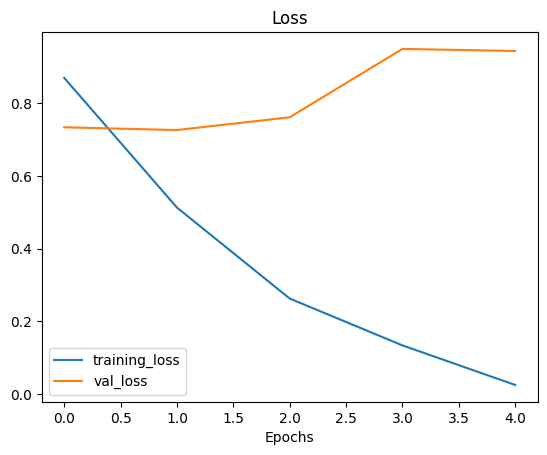

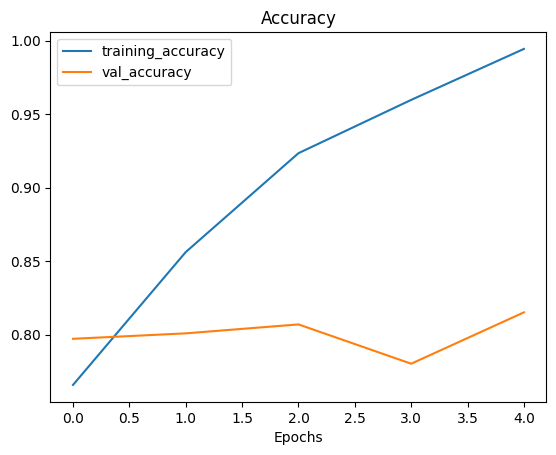

In [41]:
plot_loss_curves(fine_tuned_history)

<Axes: >

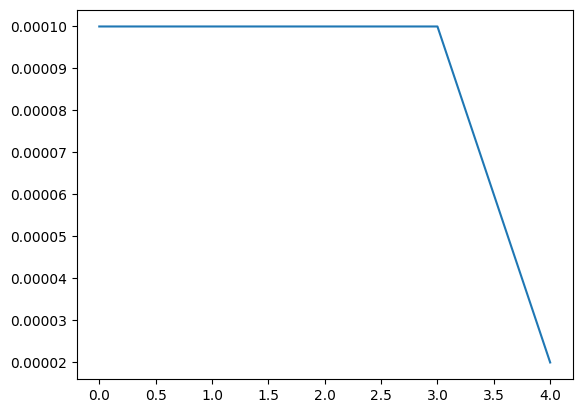

In [45]:
import pandas as pd

pd.DataFrame(fine_tuned_history.history)['lr'].plot()

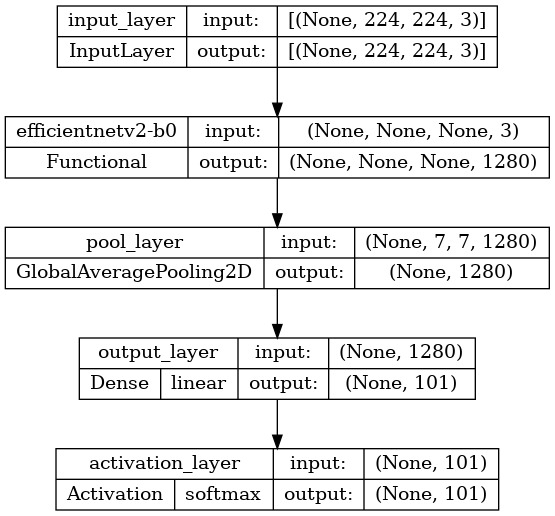

: 

In [46]:
tf.keras.utils.plot_model(fine_tuned_model, show_shapes=True, show_layer_names=True, show_layer_activations=True)